In [1]:

import skimage
import tensorflow as tf
import pandas as pd
import tarfile
import tqdm
import cv2
import os
from keras.models import load_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from get_embeddings import get_embeddings


In [3]:
#Load celebs images and embeddings
celeb = pd.read_pickle("celeb40_full_identities_pickle")
images = celeb["images"]
images = np.stack(images)
embeddings = celeb["embeddings"]
embeddings = np.stack(embeddings)

## Method with Random k Perturbations (as in Utkin) 

In [6]:

def normalize(v):#all values between 0 and 1
    return (v - np.min(v)) / (np.max(v) - np.min(v))

    
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))
    plt.axis("off")
    
decoder = load_model("decoder_celeb.h5")#("decoder_in_celeb2.h5")#("decoder_celeb_200_onward.h5")

def get_most_important_features(image1, image2, embedding1, embedding2, same_category= True, plot = False, k = 100, N= 50, q = 1000): 
    #k= number of embedding features to be perturbed.
    #N = number of embeddings for the average perturbation.
    
    
    #Select embedding most important features     
    print( np.dot(embedding1,embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2)))
    dist = abs(embedding1 - embedding2)

    
    if same_category:
        idx_h = np.argpartition(dist, k) #index of k elements with smallest difference
    else:
        idx_h = np.argpartition(dist, -k) #index of k elements with largest difference
        
    zero_emb = np.zeros(512)


    
    x = decoder.predict((embedding2)[None])[0] #original reconstruction
    
    changes = np.zeros((40,40,3))


    perturbation = np.zeros(512)# initialize perturbation vector.
    sigma = np.amin(dist)*0.1 

    #generation of N perturbation vectors, and calculation of mean changes in perturbed reconstruction x_til
    for j in range(N): 
        if same_category: 
            idx_hk = idx_h[:k]
        else:
            idx_hk = idx_h[-k:]
          
        for i in idx_hk:
            perturbation[i] = abs(np.random.normal(0, sigma)) #random perturbations taken from a normal distribution

        x_til = decoder.predict((perturbation + embedding2)[None])[0]
        changes = changes + abs((x_til - x))

    mean_changes = changes/N

    
       
    #PLOT
    if plot:
        b = 0.7
        selection = (normalize(mean_changes)> b)*1
        for i in range(selection.shape[0]):
            for j in range(selection.shape[1]):
                if 1 in selection[i,j]:
                    selection[i,j] = [1,1,0]
                #print(selection.shape)


                
        plt.subplot(1,6,1) 
        plt.title("reference")
        show_image(image1) 
        

        plt.subplot(1,6,2) 
        plt.title("original")
        show_image(image2)
        
        plt.subplot(1,6,3) 
        plt.title("reconstruido")
        show_image(x)

        
        plt.subplot(1,6,4) 
        plt.title("")
        show_image(image2 + selection*1e2)
        
        #print(selection)
        plt.subplot(1,6,5) 
        plt.title("")
        show_image(x + selection*1e2)
        
        #print(x_top_features)
        heat_map = np.zeros((40,40))
        for i in range(selection.shape[0]):
            for j in range(selection.shape[1]):
                    heat_map[i,j] = sum(mean_changes[i,j])
                    
        plt.subplot(1,6,6) 
        plt.title("")
        show_image(normalize(heat_map))
        #show_image(x + selection*100)
        
        plt.axis("off")

        plt.show()

    
    return normalize(mean_changes)


0.8436329430059144


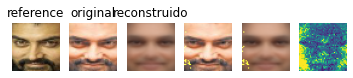

In [7]:
n = 12
person_idx = celeb.index[celeb["person"]== n].tolist()
#print(index1)
index1 = person_idx[0]
index2 = person_idx[1]
#index1 = 5
#index2 = 16

k_20= get_most_important_features(images[index1], images[index2], embeddings[index1], embeddings[index2], k = 20, same_category= True, plot = True) #images, embeddings after index2


0.8436329430059144


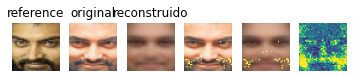

In [8]:
k_50 = get_most_important_features(images[index1], images[index2], embeddings[index1], embeddings[index2], k = 50, same_category= True, plot = True)

0.8436329430059144


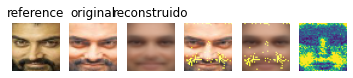

In [62]:
k_100 = get_most_important_features(images[index1], images[index2], embeddings[index1], embeddings[index2], k = 100, same_category= True, plot = True)